In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import keras
from tensorflow.keras import layers

2024-03-21 09:05:14.085503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 09:05:14.141846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 09:05:14.956297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

class CustomModel(tf.keras.Model):
    def __init__(self, num_classes=5):
        super(CustomModel, self).__init__()
        self.num_classes = num_classes
        self.resizing = tf.keras.layers.Resizing(224, 224)

        # Data augmentation layers
        self.data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
        ])
        
        # Load the ResNet50 base model
        self.base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        # Freeze the layers of the base model
        self.base_model.trainable = False

        # Additional layers on top of the base model
        self.global_avg_pooling = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(256, activation='relu')
        # self.dropout = layers.Dropout(0.5)  # Uncomment if dropout is needed
        self.dense2 = layers.Dense(128, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='linear')

    def call(self, inputs, training=False):
        x = self.resizing(inputs)
        x = self.data_augmentation(x, training=training)
        x = self.base_model(x, training=False)  # Base model is always in inference mode
        x = self.global_avg_pooling(x)
        x = self.dense1(x)
        # x = self.dropout(x, training=training)  # Uncomment if dropout is needed
        x = self.dense2(x)
        return self.output_layer(x)

# Instantiate the model
model = CustomModel(num_classes=5)

2024-03-21 09:05:16.231917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 09:05:16.268834: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [88]:
class OnlyRGB(tf.keras.Model):
    def __init__(self, hub_url = None):
        super(OnlyRGB, self).__init__()
        hub_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/4"
        self.hub_layer = hub.KerasLayer(hub_url, input_shape=(128, 128, 3), trainable=False)  # Or True, depending on your needs
        self.dense1 = tf.keras.layers.Dense(30, activation='relu')
        self.dense2 = tf.keras.layers.Dense(5, activation='linear')

    def call(self, inputs):
        x = self.hub_layer(inputs)
        x = self.dense1(x)
        return self.dense2(x)

In [1]:


import tensorflow as tf
import tensorflow_hub as hub

class OnlyRGB_aug(tf.keras.Model):
    def __init__(self, hub_url=None):
        super(OnlyRGB_aug, self).__init__()
        hub_url = hub_url or "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/4"
        self.resize = tf.keras.layers.Resizing(128, 128)
        self.hub_layer = hub.KerasLayer(hub_url, input_shape=(128, 128, 3), trainable=False)
        
        # Define the data augmentation layers and additional layers as part of a Sequential model
        self.seq = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomBrightness(0.2, value_range=(0, 1)),
            tf.keras.layers.Dense(1000, activation='relu'),
            tf.keras.layers.Dense(1000, activation='relu'),
            tf.keras.layers.Dense(5, activation='linear')
        ])

    def call(self, inputs, training=False):
        x = self.resize(inputs)
        x = self.hub_layer(x)
        if training:
            x = self.seq(x, training=training)
        else:
            # Skip data augmentation layers if not training
            x = self.seq.layers[-3](x)
            x = self.seq.layers[-2](x)  # Apply the Dense(30) layer
            x = self.seq.layers[-1](x)  # Apply the Dense(5) layer
        return x

2024-03-21 08:44:44.957859: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 08:44:45.240874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 08:44:45.927537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#model = OnlyRGB_aug()
#model.build([None, 128, 128, 3])
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
def prepare_image(image_path, target_size=(128, 128)):
    """
    Load an image file and prepare it for model prediction.
    """
    # Load the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize(target_size)
    
    # Convert the image to a numpy array and normalize it
    image = np.array(image) / 255.0
    
    # Ensure it's in the right shape (batch size, height, width, channels)
    #image = np.expand_dims(image, axis=0)
    
    return image

In [29]:
image_path = '/home/julius/Hack/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1563216717/rgb.png'
prepared_image = prepare_image(image_path, target_size=(128, 128))
prepared_image.shape


(1, 128, 128, 3)

In [4]:
import pandas as pd

df = pd.read_pickle('df.pkl')


In [5]:
y = df.iloc[:,1:-2].values
X = df.iloc[:,-2:].values

In [6]:
y.shape

(3261, 5)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = scaler.fit_transform(y)

In [8]:
X = [e[0][None] for e in df['image']]

In [9]:
del df


In [10]:
X = np.concatenate(X, axis=0)
X.shape

(3261, 300, 300, 3)

In [11]:
history = model.fit(X,y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
17/92 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - loss: 1.0247

KeyboardInterrupt: 

In [105]:
model.save('onlyrgb_100epoch.keras')

In [ ]:
model = keras.models.load_model('onlyrgb_100epoch.keras')

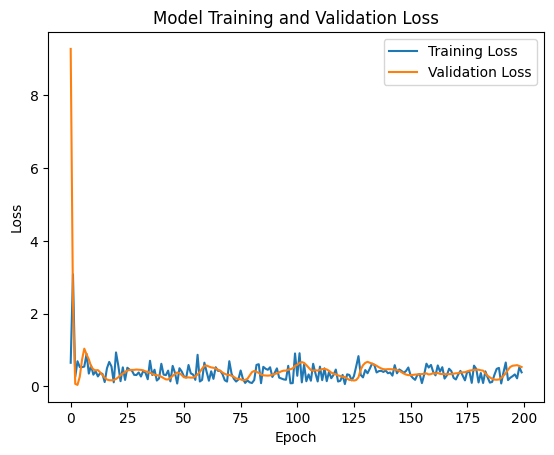

In [129]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title and labels
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

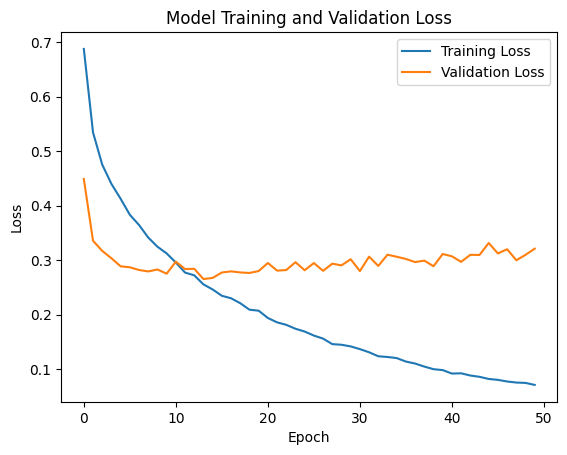

In [106]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title and labels
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [27]:
model.predict(prepared_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[-0.24619696, -0.32881746, -1.3953488 , -0.68196774]],
      dtype=float32)

In [14]:

# Use the model to predict
# Note: You may need to check the specific model documentation for the correct input and output processing
predictions = model(prepared_image)

TypeError: 'AutoTrackable' object is not callable